In [1]:
import torch
import contextlib
from torch.optim import Optimizer
from gptopt.train import train
from gptopt.optim.utils import get_scheduler, get_optimizer
from gptopt.utils import hash_config, set_seed, get_worker_info
from gptopt.model import load_model
from gptopt.data.data_utils import get_data_dir
from gptopt.dataloader import ShardedDataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import copy
import json
import os
import wandb
import hydra
import time
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from gptopt.train import Logging, eval_validation_loss
from gptopt.gpt_model import CausalSelfAttention
from gptopt.utils import get_worker_info, save_checkpoint, load_checkpoint

OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16}
from gptopt.optim.pdhg import pdhg_method_AB, prox_l1, check_dual_feasible, AttnPDHGAdamW



/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train(train_dataloader, val_dataloader, model, optimizer, training_params, logging_params, scheduler=None, ckpt_dir="", wandb_run=None):
    record_pdhg_info = [0, 10, 100]
    world_size, rank, local_rank, device  = get_worker_info()
    master_process = (rank == 0)
    logger = Logging()
    logger.pdhg_residuals = []
    optimizer_name = optimizer.__class__.__name__
    if 'momo' in optimizer_name.lower() or 'nesgd' in optimizer_name.lower():
        pass_loss = True
    else:
        pass_loss = False
    if master_process: print(f"Set pass_loss to {pass_loss} for optimizer {optimizer_name}")

    autocast_ctxt = contextlib.nullcontext()
    if training_params['autocast']:
        autocast_ctxt = torch.autocast(device_type=device, dtype=typedict[training_params['mixed_precision']])     
    B, T = training_params['batch_size'], training_params['context_length']
    grad_accum_steps = int(training_params['tokens_processed'] / (world_size*B*T))
    val_accum_steps = int(logging_params['val_tokens_processed'] / (world_size*B*T))
    if master_process: print(f"Accumulate gradient for {grad_accum_steps} steps")
    total_iterations = int(training_params['num_epochs'] * len(train_dataloader) / training_params['tokens_processed'])
    max_grad_norm = training_params['gradnorm'] if training_params['gradnorm'] != 0. else float('inf')

    load_ckpt_step = logging_params['load_ckpt_step']
    if load_ckpt_step != 0:
        model, optimizer, train_dataloader, scheduler = load_checkpoint(ckpt_dir, load_ckpt_step, model, \
                                                        optimizer, train_dataloader, scheduler=None)
    if ckpt_dir == "":
        print("Will not save checkpoints as no directory is specified")

    # Training loop
    for epoch in range(training_params['num_epochs']):
        if master_process:
            print(f"Epoch {epoch+1} of {training_params['num_epochs']}")

        model.train()
        start_epoch = time.time()
        start_time = time.time() 
        loss_accum = 0.
        step = 1 if load_ckpt_step == 0 else int(load_ckpt_step)  # micro-step counter
        opt_step = 0 if load_ckpt_step == 0 else int(load_ckpt_step) // grad_accum_steps  # optimizer step counter
        optimizer.zero_grad(set_to_none=True)
        if step != 1 and master_process:
            print(train_dataloader.get_state())
            print(f"Resuming from micro_step={step}, opt_step={opt_step}")

        for batch in train_dataloader:
            with autocast_ctxt:
                output = model(input_ids=batch[0], labels=batch[1])
                loss = (output.loss if hasattr(output, "loss") else output[1])
                loss /= grad_accum_steps

            loss_accum += loss.detach()
                
            # Check if accummulated enough gradients to take a step
            if step % grad_accum_steps != 0:
                with (model.no_sync() if world_size > 1 else contextlib.nullcontext()):
                    loss.backward()
            else:
                loss.backward()
                norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                if world_size > 1: dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
                if pass_loss:
                    _, pdhg_residuals = optimizer.step(closure=None, loss=loss_accum)
                else:
                    _, pdhg_residuals = optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                if scheduler is not None:
                    scheduler.step()

                if step % grad_accum_steps in record_pdhg_info:
                    logger.pdhg_residuals.append(pdhg_residuals)
                    
                #bookkeeping
                torch.cuda.synchronize()
                step_time = time.time() - start_time
                # Count an optimizer step
                opt_step += 1
                if master_process and wandb_run is not None:
                    wandb_log_dict = {
                        "train/loss": loss_accum.item(), 
                        "train/grad_norm": norm.item(),
                        "train/step_time": step_time,
                        "train/step": opt_step,
                        "train/micro_step": step
                    }
                    if getattr(model.config, "record_kq_max", False):
                        base_model = getattr(model, "module", model)
                        kq_max = None
                        for m in base_model.modules():
                            if isinstance(m, CausalSelfAttention) and getattr(m, "kq_max", None) is not None:
                                v = m.kq_max
                                if kq_max is None or v > kq_max:
                                    kq_max = v
                        if kq_max is not None:
                            wandb_log_dict["train/kq_max"] = kq_max
                            logger.kq_max.append(kq_max)
                    if hasattr(optimizer, 'step_size_list'):
                        wandb_log_dict["train/step_size_list"] = optimizer.step_size_list
                    for param_group_ix, param_group in enumerate(optimizer.param_groups):
                        wandb_log_dict[f"train/lr_{param_group_ix}"] = param_group['lr']
                    wandb_run.log(wandb_log_dict)
                logger.step_times.append(step_time)  # Are these different across ranks?
                logger.grad_norms.append(norm.item())
                for param_group in optimizer.param_groups:
                    logger.learning_rates.append(param_group['lr'])
                logger.losses.append(loss_accum.item())
                if hasattr(optimizer, 'step_size_list'):  
                    logger.step_size_list = optimizer.step_size_list  
                
                if (opt_step % logging_params['log_step'] == 0) & master_process:
                    tps = training_params["tokens_processed"] / step_time
                    print(f"Step {opt_step} of {total_iterations} (optimizer steps).")
                    print(f"Time taken : {step_time*1000:0.1f}ms | Tokens/s : {tps/1000:0.1f}k | Loss : {loss_accum.item():0.3f} | Accum: {grad_accum_steps} micro-steps/opt-step")
                    
                if (opt_step % logging_params['val_step'] == 0):
                    val_loss = eval_validation_loss(model, val_dataloader, val_accum_steps, autocast_ctxt)
                    if master_process and wandb_run is not None:
                        wandb_run.log({"val/loss": val_loss.item(), "val/step": opt_step, "val/micro_step": step})
                    logger.val_losses.append(val_loss.item())

                if (opt_step % logging_params['save_ckpt_step'] == 0) & (ckpt_dir != ""):
                    save_checkpoint(ckpt_dir, step, model, optimizer, loss_accum.item(),
                                    train_dataloader, scheduler, logging_params['keep_last'])
                    
                    if master_process:
                        with open(ckpt_dir + '/log.json', 'w') as file:
                            json.dump(logger.__dict__, file)
                loss_accum = 0.
                start_time = time.time() 
            step += 1
            
            
        print(f"In rank: {rank}, epoch {epoch+1}, Train Loss: {logger.losses[-1]}")
        print(f"In rank: {rank}, time taken for epoch {epoch+1} : ", time.time() - start_epoch)
        
        # Evaluate on val set, and save final values
        val_dataloader.reset()
        val_loss = eval_validation_loss(model, val_dataloader, 0, autocast_ctxt)
        logger.val_losses.append(val_loss.item())
        print(f"In rank: {rank}, epoch {epoch+1}, Validation Loss: {val_loss.item()}") 
        if getattr(model.config, "record_kq_max", False):
            base_model = getattr(model, "module", model)
            kq_max = None
            for m in base_model.modules():
                if isinstance(m, CausalSelfAttention) and getattr(m, "kq_max", None) is not None:
                    v = m.kq_max
                    if kq_max is None or v > kq_max:
                        kq_max = v  
                        logger.val_kq_max.append(kq_max)     
        if (ckpt_dir != ""):
            save_checkpoint(ckpt_dir, step, model, optimizer, logger.losses[-1],
                        train_dataloader, scheduler, logging_params['keep_last'])        
            if master_process:
                with open(ckpt_dir + '/log.json', 'w') as file:
                    json.dump(logger.__dict__, file)
        if master_process and wandb_run is not None:
            wandb_log_dict = {
                "val/loss": val_loss.item(),
                "val/step": opt_step,
                "val/micro_step": step,
                "train/loss": logger.losses[-1],
                "train/step": opt_step,
                "train/micro_step": step,
            }
            if getattr(model.config, "record_kq_max", False) and kq_max is not None:
                    wandb_log_dict["val/kq_max"] = kq_max
            wandb_run.log(wandb_log_dict)

    if hasattr(optimizer, 'step_size_list'):      # Check if optimizer has a step_size_list attribute
        logger.step_size_list = optimizer.step_size_list  
    return logger

In [ ]:
@hydra.main(version_base=None, config_path="/mnt/home/tparshakova/Documents/GPT-opt/hydra_conf", config_name="config")
def main(config: DictConfig):
    set_seed(42)

    # Establish Hydra run directory for saving outputs
    hydra_run_dir = HydraConfig.get().runtime.output_dir
    os.makedirs(hydra_run_dir, exist_ok=True)

    # First set up DDP
    ddp = int(os.environ.get("RANK", -1)) != -1  # is this a ddp run?
    if ddp:
        # use of DDP atm demands CUDA, we set the device appropriately according to rank
        assert torch.cuda.is_available(), "for now i think we need CUDA for DDP"
        dist.init_process_group(backend="nccl")
    world_size, rank, local_rank, device = get_worker_info()
    master_process = rank == 0  # this process will do logging, checkpointing etc.
    device_type = "cuda" if device.startswith("cuda") else "cpu"
    print(f"Using device: {device}")

    # Set the training parameters
    training_params = config["training"]["training_params"]
    opt_config = config["optimizer"]["optimizer_params"]
    logging_config = config["logging"]["logging_params"]
    model_config = config["model"]["config"]
    model_name = config["model"]["name"]
    # Logging
    outputname = HydraConfig.get().job.config_name
    # Save results into Hydra's run directory for this job
    logging_config["results_dir"] = hydra_run_dir
    output_dir = hydra_run_dir

    CKPT_DIR = logging_config["ckpt_dir"]
    ckpt_dir_base = f"{CKPT_DIR}/{outputname}/" if CKPT_DIR != "" else ""
    if master_process:
        print(f"Training on dataset {config['data']['dataset']['name']}")
        os.makedirs(output_dir, exist_ok=True)
        if CKPT_DIR != "":
            os.makedirs(ckpt_dir_base, exist_ok=True)

    # Load model
    model = load_model(model_name, model_config, device)
    torch.set_float32_matmul_precision(training_params["tensorcore_precision"])

    # Load data
    data_dir = get_data_dir(config["data"]["dataset"]["name"])
    dataset_path = data_dir + f"/{config['data']['dataset']['name']}-gpt2/"
    if master_process:
        print(f"Load data from {dataset_path}")
    B, T = training_params["batch_size"], training_params["context_length"]
    assert training_params["tokens_processed"] % (world_size * B * T) == 0
    num_microbatches = int(
        training_params["tokens_processed"] / (world_size * B * T)
    )

    train_dataloader = ShardedDataLoader(dataset_path, B, T, "train", device)
    val_dataloader = ShardedDataLoader(dataset_path, B, T, "val", device)
    total_iterations = int(
        training_params["num_epochs"]
        * len(train_dataloader)
        / training_params["tokens_processed"]
    )
    if master_process:
        print(
            f"Length of train dataset : {len(train_dataloader)/1e6:0.1f} million tokens"
        )
        print(
            f"Length of validation dataset : {len(val_dataloader)/1e6:0.1f} million tokens"
        )
        print(f"Total number of iterations : {total_iterations}")

    print()
    if master_process:
        print(
            f"Training with optimizer {opt_config['name']} and learning rate {opt_config['lr']}"
        )

    # Generate hash for the current optimizer configuration
    config_hash = hash_config(
        OmegaConf.to_container(opt_config),
        OmegaConf.to_container(training_params),
        OmegaConf.to_container(model_config),
    )
    file_name = (
        f"{opt_config['name']}-lr-{opt_config['lr']}-{opt_config['lr_schedule']}"
    )
    if "muon_lr" in opt_config:
        file_name += f"-muonlr-{opt_config['muon_lr']}"
    file_name += f"-{config_hash}"
    output_path = os.path.join(output_dir, file_name + ".json")
    ckpt_dir = (
        os.path.join(ckpt_dir_base, file_name) + "/" if CKPT_DIR != "" else ""
    )

    # copy model to ensure consistency
    model_copy = copy.deepcopy(model).to(device)
    opt_name = opt_config["name"]
    # Setup optimizer: allow using local AttnPDHGAdamW in this test
    if opt_name == "attn_pdhg_adamw":
        lr = float(opt_config.get("lr", 1e-3))
        betas = tuple(opt_config.get("betas", (0.9, 0.999)))
        eps = float(opt_config.get("eps", 1e-8))
        weight_decay = float(opt_config.get("weight_decay", 0.01))
        qk_lr_scale = float(opt_config.get("qk_lr_scale", 1.0))
        max_norm_tr = float(opt_config.get("max_norm_tr", 1.0))
        optimizer = AttnPDHGAdamW(
            model_copy.named_parameters(),
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            qk_lr_scale=qk_lr_scale,
            max_norm_tr=max_norm_tr,
        )
        use_my_adamw = True
    else:
        optimizer_obj, hyperp = get_optimizer(opt_config, lr=opt_config["lr"])
        use_my_adamw = False

    if training_params["compile"]:
        if master_process:
            print("Compiling model")
        model_copy = torch.compile(model_copy)

    if ddp:
        model_copy = DDP(model_copy, device_ids=[local_rank])

    if not use_my_adamw:
        p = (
            model_copy.named_parameters()
            if ("muon" in opt_name or "scion" in opt_name)
            else model_copy.parameters()
        )
        optimizer = optimizer_obj(p, **hyperp)

    scheduler = get_scheduler(
        opt_config, optimizer, total_iterations=total_iterations
    )

    # Initialize wandb
    if master_process and logging_config.get("wandb", None) is not None:
        config_no_optimizer = copy.deepcopy(config)
        config_no_optimizer = OmegaConf.to_container(
            config_no_optimizer, resolve=True
        )
        config_no_optimizer.pop("optimizer_params", None)

        wandb_config = dict(
            one_optimizer_params=opt_config,
            **config_no_optimizer,
            world_size=world_size,
        )

        wandb_args = dict(logging_config["wandb"])
        wandb_args.setdefault(
            "dir", f"{logging_config['results_dir']}/../wandb"
        )

        wandb_run = wandb.init(
            **wandb_args,
            config=wandb_config,
            reinit="create_new",
        )
    else:
        wandb_run = None

    # Train
    try:
        logger = train(
            train_dataloader,
            val_dataloader,
            model_copy,
            optimizer,
            training_params,
            scheduler=scheduler,
            ckpt_dir=ckpt_dir,
            logging_params=logging_config,
            wandb_run=wandb_run,
        )
    finally:
        if master_process and wandb_run is not None:
            wandb_run.finish()

    # Save
    if master_process:
        logger.name = opt_config["name"] + "-lr-" + str(opt_config["lr"])
        if "muon_lr" in opt_config:
            logger.name += f"-muonlr-{opt_config['muon_lr']}"
        if "muon_lr_ratio" in opt_config:
            logger.name += f"-muonlr_ratio-{opt_config['muon_lr_ratio']}"
        if os.path.exists(output_path):
            print(f"File {output_path} already exists. Overwriting")
        with open(output_path, "w") as file:
            json.dump(logger.__dict__, file)
        print(f"Saved output to {output_path}")

    if ddp:
        dist.destroy_process_group()
    return logger

In [4]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_pdhg_adamw",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    logger = main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_pdhg_adamw and learning rate 0.001


wandb: Currently logged in as: tparshakova (tparshakova-simons-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Set pass_loss to False for optimizer AttnPDHGAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 6.725948333740234
In rank: 0, time taken for epoch 1 :  213.139493227005
Rank 0 reached end of val dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
Validation Loss: 6.778471946716309
In rank: 0, epoch 1, Validation Loss: 6.778471946716309


train/grad_norm,██▃▂▂▂▁▁▁▁▁▁▁▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/kq_max,▁▁▁▁▁▁▁▁▁▂▇▇█▇▄▇▁▇▇█▃▂▂█▂▂▅▇▂▇▇▂▂▇█▄▇▆▁▁
train/loss,█▆▂▁▃▁▁▁▁▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▂▁▂▂▁▂▁▂▁▁▂▂▂▂▂
train/lr_0,██████████████████▇▇▇▇▇▆▆▆▅▅▄▄▄▄▄▄▃▃▂▁▁▁
train/micro_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train/step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
train/step_time,█▁▁▁▁▂▂▁▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁
val/kq_max,▁
val/loss,▁
val/micro_step,▁
+1,...


Saved output to /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pdhg_adamw/bs-4-lr-0.001-wd-0/attn_pdhg_adamw-lr-0.001-constant-linear-8845e06a3a9b36ab89bb2679d8318534.json


In [13]:
import json
from types import SimpleNamespace

with open("outputs/gpt-tiny/default/tiny_shakespeare/attn_pdhg_adamw/bs-4-lr-0.001-wd-0/attn_pdhg_adamw-lr-0.001-constant-linear-8845e06a3a9b36ab89bb2679d8318534.json") as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

In [14]:
import matplotlib.pyplot as plt

def plot_residuals(residuals_by_layer):
    # residuals_by_layer: {layer_idx: {'r1': [...], 'r2': [...], 'r1_rel': [...], 'r2_rel': [...]} }
    layer_indices = sorted(residuals_by_layer.keys())
    n_layers = len(layer_indices)

    fig, ax = plt.subplots(n_layers, 2, figsize=(10, 3 * n_layers), sharex=True)
    if n_layers == 1:
        ax = ax.reshape(1, 2)

    spec = [
        ('r1', 'r2', 'Absolute residuals', r'$r_1$', r'$r_2$'),
        ('r1_rel', 'r2_rel', 'Relative residuals', r'$r_1^{\text{rel}}$', r'$r_2^{\text{rel}}$')
    ]

    for row, layer_idx in enumerate(layer_indices):
        layer_res = residuals_by_layer[layer_idx]
        for col, (k1, k2, title, l1, l2) in enumerate(spec):
            d1, d2 = layer_res.get(k1, []), layer_res.get(k2, [])
            if len(d1) and len(d2):
                ax[row, col].plot(d1, label=l1)
                ax[row, col].plot(d2, label=l2)
                ax[row, col].set(yscale='log', title=f"Layer {layer_idx} – {title}", xlabel='iteration')
                ax[row, col].grid(True, which='both', ls='--', alpha=0.4)
                ax[row, col].legend()
            else:
                ax[row, col].axis('off')

    plt.tight_layout()

iteration=0


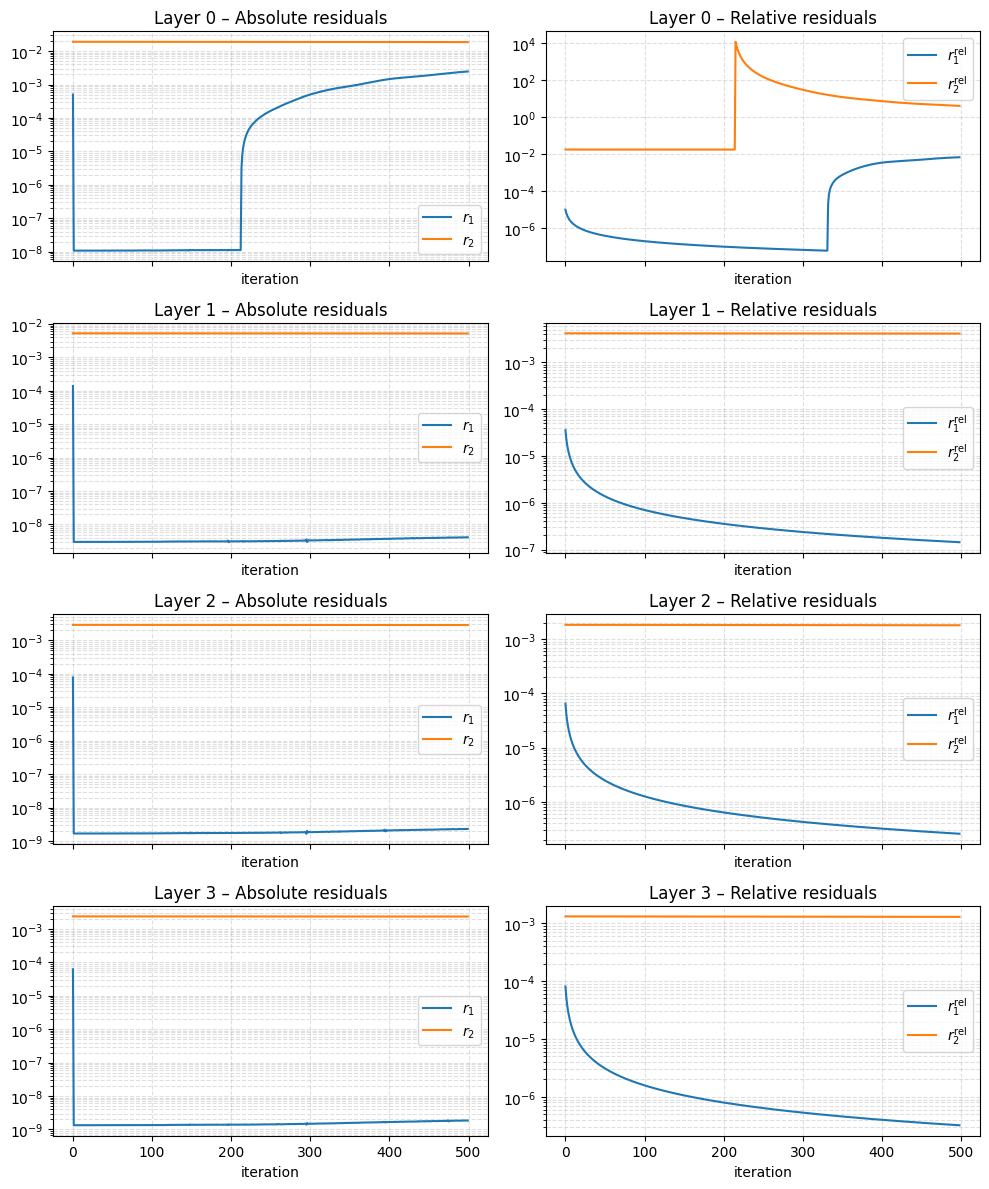

In [15]:
it = 0
print(f"iteration={it}")
plot_residuals(logger.pdhg_residuals[0])

iteration=146


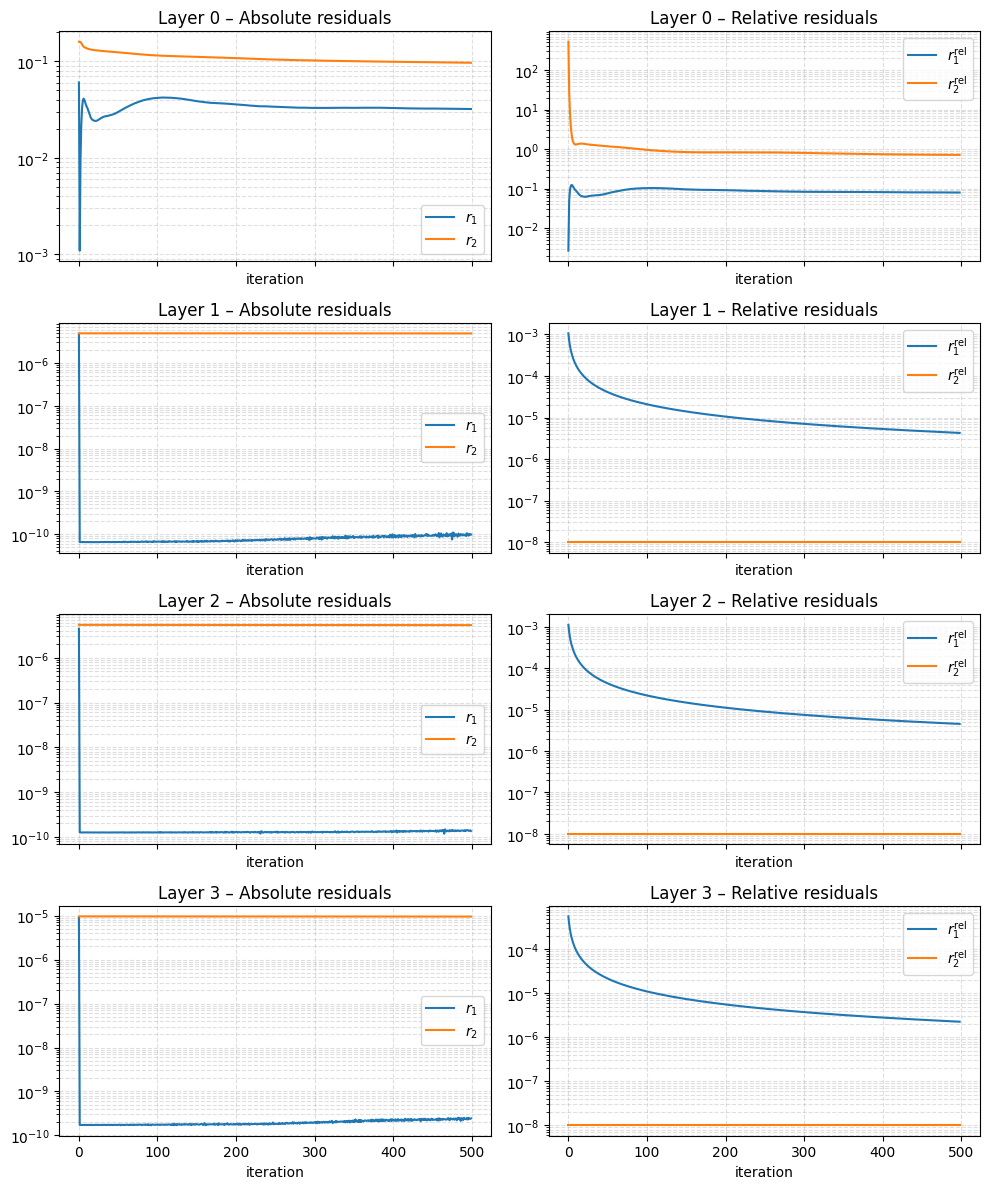

In [ ]:
it = len(logger.pdhg_residuals) - 1
print(f"iteration={it}")
plot_residuals(logger.pdhg_residuals[it])

In [10]:
len(logger.pdhg_residuals)

1

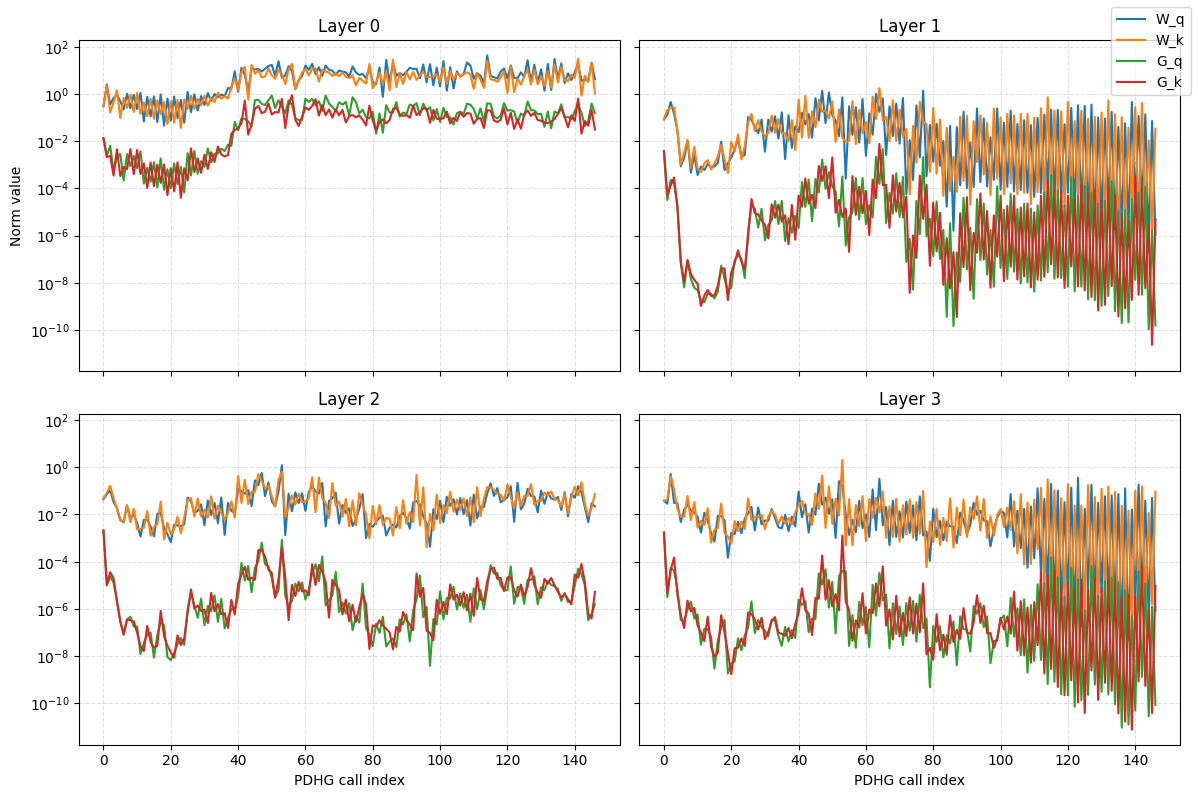

In [17]:
import numpy as np
import matplotlib.pyplot as plt

layer_indices = sorted({
    layer_idx
    for it_res in logger.pdhg_residuals
    for layer_idx in it_res.keys()
})

calls = np.arange(len(logger.pdhg_residuals))

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, layer_idx in zip(axes, layer_indices):
    W_q_norms, W_k_norms, G_q_norms, G_k_norms = [], [], [], []
    for it_res in logger.pdhg_residuals:
        layer_res = it_res.get(layer_idx)
        if layer_res is None:
            W_q_norms.append(np.nan); W_k_norms.append(np.nan)
            G_q_norms.append(np.nan); G_k_norms.append(np.nan)
        else:
            W_q_norms.append(layer_res["W_q_norm"])
            W_k_norms.append(layer_res["W_k_norm"])
            G_q_norms.append(layer_res["G_q_norm"])
            G_k_norms.append(layer_res["G_k_norm"])

    ax.plot(calls, W_q_norms, label="W_q")
    ax.plot(calls, W_k_norms, label="W_k")
    ax.plot(calls, G_q_norms, label="G_q")
    ax.plot(calls, G_k_norms, label="G_k")
    ax.set_title(f"Layer {layer_idx}")
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.4)

axes[0].set_ylabel("Norm value")
axes[2].set_xlabel("PDHG call index")
axes[3].set_xlabel("PDHG call index")

# One shared legend for all axes
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()